# This notebook is used to evaluate the performance of trained model

In [1]:
%load_ext autoreload
%autoreload 2

In [104]:
from typing import Counter

In [88]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

In [142]:
metrics = pd.read_csv(
    "../logs/ner_ehr_lstm/version_3/metrics.csv",
    engine="python")
# metrics.dropna(inplace=True)

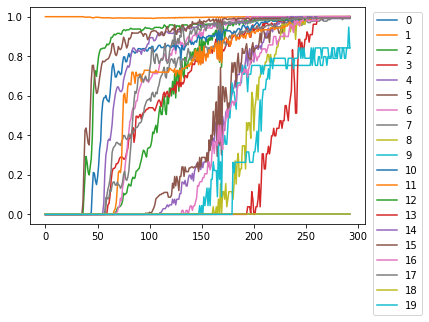

In [143]:
for col in metrics.columns:
    if col.startswith("val_acc_label") and col.endswith("epoch"):
        plt.plot(
            metrics[~metrics[col].isna()]["epoch"],
            metrics[~metrics[col].isna()][col], 
            label=col.split("=")[1].split("_")[0])
      
        
plt.legend(bbox_to_anchor=(1.01, 1.))
plt.show()

In [ ]:
from pytorch_lightning.loggers import CSVLogger

In [ ]:
csv_logger = CSVLogger(
    save_dir=os.getcwd(),
    name="test") 

In [ ]:
csv_logger.version

0

In [94]:
from ner_ehr.utils import load_np

In [139]:
arr = load_np(
    "../logs/ner_ehr_lstm/version_3/cm_epoch=269.npy")

<AxesSubplot:>

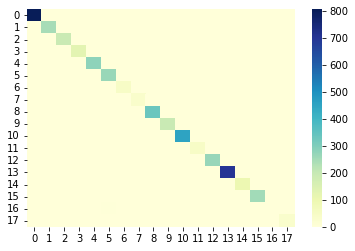

In [140]:
sns.heatmap(arr[2:,2:], cmap="YlGnBu")

In [141]:
arr[2:,2:]

array([[806,   0,   0,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0],
       [  0, 246,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0],
       [  0,   0, 194,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   2],
       [  2,   0,   0, 126,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 282,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 266,   0,   0,   0,   0,   0,   0,   0,
          2,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,  48,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   2,  36,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 336,   0,   0,   0,   0,
          0,   0,   2,   0,   0],
       [  0,   0,   0,   0,   0,   0,

In [91]:
import os
from glob import glob
from pathlib import Path
from typing import List, Union

import yaml
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import pandas as pd

from copy import deepcopy

In [92]:
from ner_ehr.data.ehr import EHR
from ner_ehr.data.utils import df_to_namedtuples
from ner_ehr.data.variables import AnnotationTuple



from ner_ehr.training.models import LitLSTMNERTagger
from ner_ehr.training.datasets import EHRDataset, EHRBatchCollator
from ner_ehr.data.vocab import TokenEntityVocab

In [93]:
def read_annotatedtuples(dir: Union[str, Path]) -> List[AnnotationTuple]:
    """Read annotated tuples from CSVs present inside given directory.

    Args:
        dir: directory containing CSVs with annotated tokens

    Returns:
        annotatedtuples: list of AnnotatedToken tuples
                [
                    Annotation(
                        doc_id='100035',
                        token='Admission',
                        start_idx=0,
                        end_idx=9,
                        entity='O'),
                    Annotation(
                        doc_id='100035',
                        token='Date',
                        start_idx=10,
                        end_idx=14,
                        entity='O'),
                ]
    """
    annotatedtuples = []
    for fp in glob(os.path.join(dir, r"*.csv")):
        annotatedtuples += df_to_namedtuples(
            name=AnnotationTuple.__name__,
            df=EHR.read_csv_tokens_with_annotations(fp),
        )

    return annotatedtuples

In [71]:
hparams = yaml.safe_load(
    open("../logs/ner_ehr_lstm/version_6/hparams.yaml"))

ckpt = (
    "../logs/ner_ehr_lstm/version_6/checkpoints/"
    "epoch=43-step=1099-val_loss=0.138.ckpt")

DEFAULT_DEVICE_TYPE = torch.device(
    "cuda:0" if torch.cuda.is_available() else "cpu"
)

train_annotatedtuples = read_annotatedtuples(
    dir=hparams["parser_args"]["processed_data_dir_train"])

vocab = TokenEntityVocab(to_lower=True if hparams["parser_args"]["to_lower"]=="Y" else False)
vocab.fit(annotatedtuples=train_annotatedtuples)

test_ds = EHRDataset(
    dir="../processed/test", 
    vocab=vocab, 
    seq_length=hparams["parser_args"]["max_seq_len"], 
    annotated=True)

In [72]:
vocab.num_uniq_tokens

30596

In [73]:
collate_fn = EHRBatchCollator(return_meta=True)
test_dl = DataLoader(
    dataset = test_ds, 
    collate_fn=collate_fn,
    batch_size=64, 
    shuffle=False)

In [74]:
lit_lstm = LitLSTMNERTagger(
    embedding_dim=hparams["embedding_dim"],
    vocab_size=hparams["vocab_size"],
    hidden_size=hparams["hidden_size"],
    num_classes=hparams["num_classes"],
    num_lstm_layers=hparams["num_lstm_layers"],
    lstm_dropout=hparams["lstm_dropout"],
    bidirectional=hparams["bidirectional"],
)

lit_lstm.load_state_dict(
    torch.load(
        ckpt, 
        map_location=DEFAULT_DEVICE_TYPE)["state_dict"],
)

<All keys matched successfully>

In [75]:
true = []
pred = []

# lstm_ner_tagger.lstm_ner_tagger.to(DEFAULT_DEVICE_TYPE)
# lstm_ner_tagger.lstm_ner_tagger.eval()
for X, Y, Meta in tqdm(test_dl, leave=False, position=0):
    with torch.no_grad():
        Y_hat = lit_lstm(X)
        Y_hat = torch.argmax(
            torch.softmax(Y_hat, dim=-1),
            dim=-1)
        
    for x, meta, y_hat in zip(X, Meta, Y_hat):
        y_hat = vocab.label_to_entity(
            labels=y_hat[:len(meta)].tolist())
        
        true += [l for l in meta]
        pred += [l[:-1] + [i] for l, i in zip(meta, y_hat)]

IndexError: index out of range in self

In [64]:
df_true = pd.DataFrame(true, columns=AnnotationTuple._fields)
df_pred = pd.DataFrame(pred, columns=AnnotationTuple._fields)

In [65]:
from sklearn.metrics import classification_report

In [67]:
print(classification_report(
    y_true=df_true["entity"].values, 
    y_pred=df_pred["entity"].values))

/home/mittal.nit/.conda/envs/ner_ehr/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mittal.nit/.conda/envs/ner_ehr/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-ADE       0.00      0.00      0.00       672
    B-Dosage       0.00      0.00      0.00      2681
      B-Drug       0.01      0.00      0.00     10582
  B-Duration       0.00      0.00      0.00       378
      B-Form       0.00      0.00      0.00      4359
 B-Frequency       0.01      0.00      0.00      4012
    B-Reason       0.00      0.00      0.00      2590
     B-Route       0.00      0.00      0.00      3513
  B-Strength       0.03      0.00      0.00      4230
       I-ADE       0.00      0.00      0.00       498
    I-Dosage       0.00      0.00      0.00      5476
      I-Drug       0.00      0.00      0.00      1878
  I-Duration       0.00      0.00      0.00       602
      I-Form       0.00      0.00      0.00      2911
 I-Frequency       0.01      0.00      0.00      7996
    I-Reason       0.00      0.00      0.00      2085
     I-Route       0.00      0.00      0.00       257
  I-Strength       0.00    

/home/mittal.nit/.conda/envs/ner_ehr/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
